**PRINCIPAL COMPONENT ANALYSIS**

In the first part of this notebook one can find implementations on pca, naive pca, iterative pca and probabilistic pca.

After that, several mock up datasets are created to test the implementations.

Finally, the methods are tested with a real dataset with missing values.

In [280]:
import numpy as np
from scipy.linalg import orth, svd

def pca_(X, r, W=None, it=1):
    "Classical PCA using SVD"

    X = X - X.mean(0)
    
    V, L, U = svd(X)
    
    F = np.matmul(V[:, :r], np.diag(L[:r]))
    
    return F, U[:r].T

def naive_pca(X, r, W, it=10):
    "Naive PCA"
    X = X - X.mean(0)
    F_ = np.zeros((X.shape[0], r))
    U_ = np.random.random((X.shape[1], r))
    N, M = X.shape
    
    for k in range(it):
        F_ = np.zeros((X.shape[0], r))
        for n in range(N):
            sum1 = np.zeros((U_.shape[1], U_.shape[1]))
            sum2 = np.zeros((U_.shape[1]))
            for m in range(M):
                sum1 += W[n,m] * (U_[m].reshape(1, -1).T @ U_[m].reshape(1, -1))
                sum2 += W[n,m] * X[n,m] * U_[m]
            F_[n] = sum2 @ np.linalg.pinv(sum1)
        
        U_ = np.zeros((X.shape[1], r))
        for m in range(M):
            sum1 = np.zeros((F_.shape[1], F_.shape[1]))
            sum2 = np.zeros((F_.shape[1]))
            for n in range(N):
                sum1 += W[n,m] * (F_[n].reshape(1, -1).T @ F_[n].reshape(1, -1))
                sum2 += W[n,m] * X[n,m] * F_[n]
            U_[m] = sum2 @ np.linalg.pinv(sum1)
        
        it+=1

    V, S, Vh = svd(U_.T @ U_)

    diag = np.diag([1 / np.sqrt(s) for s in S])
    P = V * diag
    U_ = U_ @ P
    F_ = np.matmul(F_, np.linalg.pinv(P).T)
    
    return F_, U_

def iterative_pca(X, r, W, it=10):
    "Iterative PCA"
    X = X - X.mean(0)    
    U_ = np.random.random((X.shape[1], r))
    X[W == 0] = 0
    
    for i in range(it):
        F_, U_ = pca_(X, r)
        X[W==0] = (F_ @ U_.T)[W==0]
    
    V, S, Vh = svd(U_.T @ U_)

    diag = np.diag([1 / np.sqrt(s) for s in S])
    P = V @ diag
    U_ = U_ @ P
    F_ = np.matmul(F_, np.linalg.pinv(P).T)
    
    return F_, U_    

In [281]:
def ppca(X, K, W, it=10):
    """
    Probabilistic PCA
    Uses a factorizing distribution over hidden states and hidden observations, based on https://github.com/shergreen/pyppca
    """
    N, M = np.shape(X) # N observations in M dimensions (i.e. D is number of features, N is samples)

    X = X - X.mean(0)

    X[W==0] = 0
    
    n_miss = np.sum(W[W==0])

    #initialize
    C = np.random.normal(loc=0.0, scale=1.0, size=(M,K))
    CtC = C.T @ C
    F = (X @ C) @ np.linalg.inv(CtC)
    recon = F @ C.T
    recon[W==0] = 0
    ss = np.sum((recon-X)**2) / (N*M - n_miss)

    count = 0

    #EM Iterations
    while count<it:
        Sx = np.linalg.inv(np.eye(K) + CtC/ss) # E-step, covariances
        ss_old = ss
        if n_miss:
            proj = F @ C.T
            X[W==0] = proj[W==0]
        
        F = X @ C @ Sx / ss # E-step: expected values

        FtF = F.T @ F #M-step
        C = X.T @ F @ (FtF + N*Sx).T @ np.linalg.inv((FtF + N*Sx) @ (FtF + N*Sx).T)
        CtC = C.T @ C
        ss = (np.sum((F @ C.T - X)**2) + N*np.sum(CtC*Sx) + n_miss*ss_old) / (N*M)
        #transform Sx determinant into numpy float128 in order to deal with high dimensionality
        Sx_det = np.min(Sx).astype(np.longdouble)**np.shape(Sx)[0] * np.linalg.det(Sx / np.min(Sx))       
        count+=1
        
    C = orth(C)
    covM = np.cov((X @ C).T)
    vals, vecs = np.linalg.eig(covM)
    ordr = np.argsort(vals)[::-1]
    vecs = vecs[:, ordr]

    C = C @ vecs
    F = X @ C
    return F, C

In [468]:
from scipy.linalg import subspace_angles, norm

import time
def random_comparison(K, method=pca_, W=None, it=1, SNR=None):
    "Function to compare random data using a chosen method"
    if isinstance(K, int):
        F = np.random.random((N, K))
        U = orth(np.random.random((M, K)))
        X = np.matmul(F, U.T)
        X_centered = X - X.mean(0)
        if SNR is not None:
            B = np.random.normal(0, norm(X)**2/(SNR*N*M), (N, M))
            print("Used SNR: ", norm(X)/norm(B))
            X += B
        t = time.time()
        F1, U1 = method(X, K, W, it)
        elapsed = time.time() - t
        error = norm(X_centered - np.matmul(F1,U1.T))**2/(M*N)
        return subspace_angles(F.T, F1.T)[0], subspace_angles(U, U1)[0], error, elapsed
    else:
        _comparison = []
        for k in K:    
            F = np.random.random((N, k))
            U = orth(np.random.random((M, k)))
            X = np.matmul(F, U.T)
            mean = X.mean(0)
            X_centered = X - mean
            print(norm(X))
            if SNR is not None:
                B = np.random.normal(0, norm(X)**2/(SNR*N*M), (N, M))
                print("Used SNR: ", norm(X)/norm(B))
                X += B
            t = time.time()
            F1, U1 = method(X, k, W, it)
            elapsed = time.time() - t
            error = norm(X_centered - np.matmul(F1, U1.T))**2/(M*N)
            _comparison += [[subspace_angles(F.T, F1.T)[0], subspace_angles(U, U1)[0], error, elapsed]]
        return np.array(_comparison, dtype=object)

In [418]:
N, M, K = 100, 10, 5
F = np.random.random((N, K))
U = orth(np.random.random((M, K)))
X = np.matmul(F, U.T)
print(X.shape)
mean = X.mean(0)
X_centered = X
SNR=0.01
if SNR is not None:
    B = np.random.normal(0, norm(X)**2/(SNR*N*M), (N, M))
    print("Used SNR: ", norm(X)/norm(B))
    X += B
F1, U1 = pca_(X, K, W)
error = norm(X_centered - np.matmul(F1, U1.T))**2/(M*N)
error

(100, 10)
Used SNR:  0.017908260354072867


1016.5095532778993

In [283]:
# N variables, M samples
N, M = 1000, 10
k_values = np.arange(2, M+1)

In [284]:
compPCA = random_comparison(k_values, pca_)

In [285]:
compNaive = random_comparison(k_values, naive_pca, W=np.ones((N, M)), it=50)

In [286]:
compIterative = random_comparison(k_values, iterative_pca, W=np.ones((N, M)), it=50)

In [287]:
compPPCA = random_comparison(k_values, ppca, W=np.ones((N, M)), it=50)

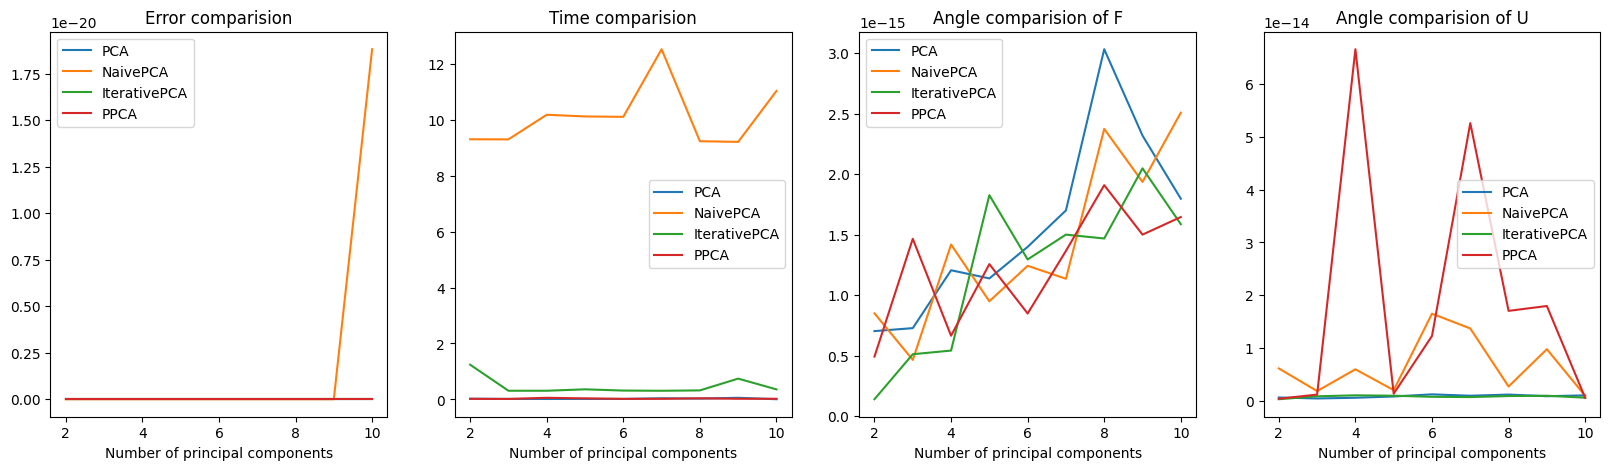

In [288]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].plot(k_values, compPCA[:, 2], label='PCA')
ax[0].plot(k_values, compNaive[:, 2], label='NaivePCA')
ax[0].plot(k_values, compIterative[:,2], label='IterativePCA')
ax[0].plot(k_values, compPPCA[:, 2], label='PPCA')
ax[0].legend()
ax[0].set_xlabel("Number of principal components")
ax[0].set_title("Error comparision")
ax[1].plot(k_values, compPCA[:, 3], label='PCA')
ax[1].plot(k_values, compNaive[:, 3], label='NaivePCA')
ax[1].plot(k_values, compIterative[:, 3], label='IterativePCA')
ax[1].plot(k_values, compPPCA[:, 3], label='PPCA')
ax[1].legend()
ax[1].set_xlabel("Number of principal components")
ax[1].set_title("Time comparision")
ax[2].plot(k_values, compPCA[:, 0], label='PCA')
ax[2].plot(k_values, compNaive[:, 0], label='NaivePCA')
ax[2].plot(k_values, compIterative[:, 0], label='IterativePCA')
ax[2].plot(k_values, compPPCA[:, 0], label='PPCA')
ax[2].set_xlabel("Number of principal components")
ax[2].legend()
ax[2].set_title("Angle comparision of F")
ax[3].plot(k_values, compPCA[:, 1], label='PCA')
ax[3].plot(k_values, compNaive[:, 1], label='NaivePCA')
ax[3].plot(k_values, compIterative[:, 1], label='IterativePCA')
ax[3].plot(k_values, compPPCA[:, 1], label='PPCA')
ax[3].set_xlabel("Number of principal components")
ax[3].legend()
ax[3].set_title("Angle comparision of U")
#plt.title("Without missing data")
plt.savefig("pca1.1.png")

In [469]:
N, M = 1000, 10
k_values = np.arange(2, 11)
compPCA = random_comparison(k_values, pca_, SNR=0.2)
compNaive = random_comparison(k_values, naive_pca, W=np.ones((N, M)), it=50, SNR=0.2)
compIterative = random_comparison(k_values, iterative_pca, W=np.ones((N, M)), it=50, SNR=0.2)
compPPCA = random_comparison(k_values, ppca, W=np.ones((N, M)), it=50, SNR=0.2)

25.89608870147212
Used SNR:  0.76981568250276
31.41571348112722
Used SNR:  0.6374155194602468
36.903736930056084
Used SNR:  0.5405652802442789
41.045702736306644
Used SNR:  0.48345996233485455
44.70499646634821
Used SNR:  0.44300812618188795
48.08073902950229
Used SNR:  0.41498089332943033
51.61030043465862
Used SNR:  0.3909222172733243
54.84431505001316
Used SNR:  0.36536600594599516
57.53831333874669
Used SNR:  0.34808897750815415
25.83270888004825
Used SNR:  0.7829041862522896


KeyboardInterrupt: 

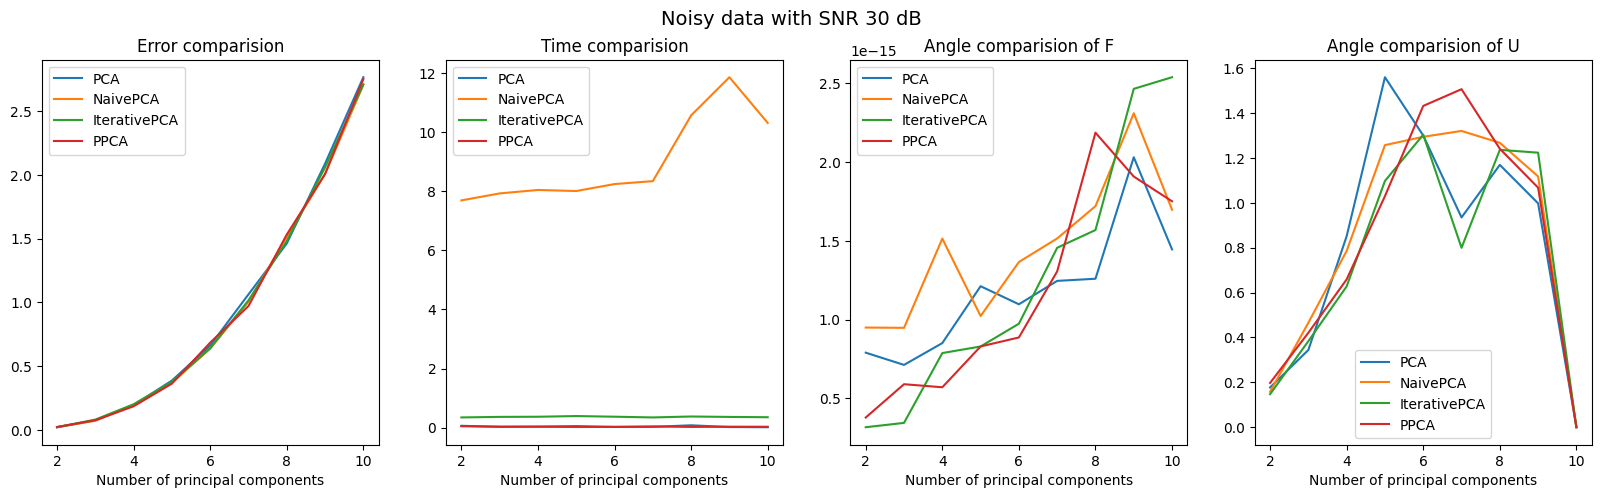

In [459]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].plot(k_values, compPCA[:, 2], label='PCA')
ax[0].plot(k_values, compNaive[:, 2], label='NaivePCA')
ax[0].plot(k_values, compIterative[:,2], label='IterativePCA')
ax[0].plot(k_values, compPPCA[:, 2], label='PPCA')
ax[0].legend()
ax[0].set_xlabel("Number of principal components")
ax[0].set_title("Error comparision")
ax[1].plot(k_values, compPCA[:, 3], label='PCA')
ax[1].plot(k_values, compNaive[:, 3], label='NaivePCA')
ax[1].plot(k_values, compIterative[:, 3], label='IterativePCA')
ax[1].plot(k_values, compPPCA[:, 3], label='PPCA')
ax[1].legend()
ax[1].set_xlabel("Number of principal components")
ax[1].set_title("Time comparision")
ax[2].plot(k_values, compPCA[:, 0], label='PCA')
ax[2].plot(k_values, compNaive[:, 0], label='NaivePCA')
ax[2].plot(k_values, compIterative[:, 0], label='IterativePCA')
ax[2].plot(k_values, compPPCA[:, 0], label='PPCA')
ax[2].set_xlabel("Number of principal components")
ax[2].legend()
ax[2].set_title("Angle comparision of F")
ax[3].plot(k_values, compPCA[:, 1], label='PCA')
ax[3].plot(k_values, compNaive[:, 1], label='NaivePCA')
ax[3].plot(k_values, compIterative[:, 1], label='IterativePCA')
ax[3].plot(k_values, compPPCA[:, 1], label='PPCA')
ax[3].set_xlabel("Number of principal components")
ax[3].legend()
ax[3].set_title("Angle comparision of U")
fig = plt.gcf()
fig.suptitle("Noisy data with SNR 30 dB", fontsize=14)
plt.savefig("pca1.2_3.png")

In [467]:
compPCA10 = random_comparison(k_values, pca_, SNR=1)
compNaive10 = random_comparison(k_values, naive_pca, W=np.ones((N, M)), it=50, SNR=0.3)
compIterative10 = random_comparison(k_values, iterative_pca, W=np.ones((N, M)), it=50, SNR=0.3)
compPPCA10 = random_comparison(k_values, ppca, W=np.ones((N, M)), it=50, SNR=0.3)

Used SNR:  3.9037635976069747
Used SNR:  3.1609136953706343
Used SNR:  2.790405682780754
Used SNR:  2.4335122410764516
Used SNR:  2.2158353781673283
Used SNR:  2.0468693073924773
Used SNR:  1.9549730997494372
Used SNR:  1.8224168995227188
Used SNR:  1.7513022954848052
Used SNR:  1.1791157450339769
Used SNR:  0.9641350031951202
Used SNR:  0.8259206997024722
Used SNR:  0.7411538536932063
Used SNR:  0.6604994042851677
Used SNR:  0.6149664998780314
Used SNR:  0.5897479186520256
Used SNR:  0.5393383764645681
Used SNR:  0.5238808926258888
Used SNR:  1.1646063940732003
Used SNR:  0.9631917815814938
Used SNR:  0.8260614682621329
Used SNR:  0.7388514441128534
Used SNR:  0.6719336420986489
Used SNR:  0.6161726099182641
Used SNR:  0.5845057163768269
Used SNR:  0.5509003544146226
Used SNR:  0.5128997327142009
Used SNR:  1.1295322844401916
Used SNR:  0.9624054235928001
Used SNR:  0.8258875991183584
Used SNR:  0.721160514985216
Used SNR:  0.6669613582576707
Used SNR:  0.6175728205902811
Used SNR:  0

In [463]:
compPCA1 = random_comparison(k_values, pca_, SNR=0.2)
compNaive1 = random_comparison(k_values, naive_pca, W=np.ones((N, M)), it=50, SNR=0.2)
compIterative1 = random_comparison(k_values, iterative_pca, W=np.ones((N, M)), it=50, SNR=0.3)
compPPCA1 = random_comparison(k_values, ppca, W=np.ones((N, M)), it=50, SNR=0.3)

Used SNR:  0.7751111018988429
Used SNR:  0.6344207420891976
Used SNR:  0.5502065607362749
Used SNR:  0.49434393400352933
Used SNR:  0.4507488141651475
Used SNR:  0.412177443974633
Used SNR:  0.3886047794314606
Used SNR:  0.366572176399159
Used SNR:  0.3429950973977622
Used SNR:  0.7853076831296899
Used SNR:  0.6503529110541489
Used SNR:  0.5492790826407744
Used SNR:  0.5000690607722507
Used SNR:  0.45059500744660763
Used SNR:  0.41186015848151303
Used SNR:  0.38758894442942615
Used SNR:  0.3675367824884116
Used SNR:  0.34785371779462104
Used SNR:  1.184051273029556
Used SNR:  0.943981349769954
Used SNR:  0.8363071636459412
Used SNR:  0.7341626057542058
Used SNR:  0.6742683428271101
Used SNR:  0.6226006906248721
Used SNR:  0.5810309698496419
Used SNR:  0.5502514115826934
Used SNR:  0.5142056821510184
Used SNR:  1.1582383180955398
Used SNR:  0.9542804609237711
Used SNR:  0.8176047039944057
Used SNR:  0.730426072559486
Used SNR:  0.6730831305626228
Used SNR:  0.6233472113012247
Used SNR: 

In [365]:
compPCA20 = random_comparison(k_values, pca_, SNR=5)
compNaive20 = random_comparison(k_values, naive_pca, W=np.ones((N, M)), it=50, SNR=5)
compIterative20 = random_comparison(k_values, iterative_pca, W=np.ones((N, M)), it=50, SNR=5)
compPPCA20 = random_comparison(k_values, ppca, W=np.ones((N, M)), it=50, SNR=5)

Used SNR:  18.974645342228936
Used SNR:  19.306026305554507
Used SNR:  19.293120306974284
Used SNR:  19.954293239461734


In [366]:
from tabulate import tabulate

methods = ['PCA', 'NaivePCA', 'IterativePCA', 'ProbabilisticPCA']
SNR = ['1 dB', '10 dB', '20 dB', '30 dB']
values = [[compPCA1[2], compNaive1[2], compIterative1[2], compPPCA1[2]],
         [compPCA10[2], compNaive10[2], compIterative10[2], compPPCA10[2]],
         [compPCA20[2], compNaive20[2], compIterative20[2], compPPCA20[2]],
         [compPCA[2], compNaive[2], compIterative[2], compPPCA[2]]]
SNRs = {'Method': methods,
        '1 dB': [compPCA1[2], compNaive1[2], compIterative1[2], compPPCA1[2]],
        '10 dB': [compPCA10[2], compNaive10[2], compIterative10[2], compPPCA10[2]],
        '20 dB': [compPCA20[2], compNaive20[2], compIterative20[2], compPPCA20[2]],
        '30 dB': [compPCA[2], compNaive[2], compIterative[2], compPPCA[2]]}
print(tabulate(SNRs,headers='keys'))

Method                 1 dB        10 dB        20 dB        30 dB
----------------  ---------  -----------  -----------  -----------
PCA               0.010912   9.7829e-05   3.81171e-05  1.29745e-05
NaivePCA          0.010331   9.9266e-05   3.44138e-05  1.38293e-05
IterativePCA      0.0101192  9.63802e-05  3.6192e-05   1.48871e-05
ProbabilisticPCA  0.0101034  0.000100832  3.17611e-05  1.44989e-05


Text(0.5, 1.0, 'K=2')

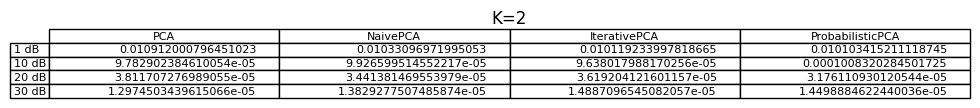

In [368]:
fig, ax = plt.subplots(figsize=(10,1))

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
plt.table(cellText=values,
          rowLabels=SNR,
          colLabels=methods,
          loc='center')
fig.tight_layout()
ax.set_title("K=2")

In [470]:
def missing_data(N, M, missing_percentage, K):
    data_size = N*M
    done = 1
    while done:
        missing_data_size = int(np.fix(missing_percentage*data_size))
        empty_indices  = np.random.permutation(data_size)
        empty_indices  = sorted(empty_indices[:missing_data_size])

        W = np.ones((N,M))
        W.ravel()[empty_indices] = 0
        if np.all(np.sum(W,1)>=K) and np.all(np.sum(W,0)>=1):
            done = 0
    return W

In [783]:
N, M = 1000, 20
k_values = 5
w_values = np.linspace(0, 0.3, 10) * 100
W = [missing_data(N, M, i, k_values) for i in w_values/100]

In [784]:
len(W[1][W[1]==0])

666

In [785]:
compPCA = [random_comparison(k_values, pca_, SNR=3, W=w) for w in W]
compNaive = [random_comparison(k_values, naive_pca, it=20, SNR=3, W=w) for w in W]
compIterative = [random_comparison(k_values, iterative_pca, it=100, SNR=3, W=w) for w in W]
compPPCA = [random_comparison(k_values, ppca, it=10000, SNR=3, W=w) for w in W]

Used SNR:  10.35721573754498
Used SNR:  10.295221451711956
Used SNR:  10.286963162007458
Used SNR:  10.524730165491036
Used SNR:  10.233185305853484
Used SNR:  10.375176327291193
Used SNR:  10.453727674462314
Used SNR:  10.497531507295708
Used SNR:  10.306962191498528
Used SNR:  10.318489245551344
Used SNR:  10.223367087563126
Used SNR:  10.320378774276813
Used SNR:  10.097633838715097
Used SNR:  10.47278072661158
Used SNR:  10.436626443514081
Used SNR:  10.435926345025491
Used SNR:  10.313860318163192
Used SNR:  10.279567798024665
Used SNR:  10.39273476115389
Used SNR:  10.48820334149913
Used SNR:  10.484308690689241
Used SNR:  10.446628699805975
Used SNR:  10.349194466891065
Used SNR:  10.47874775460913
Used SNR:  10.237075393624057
Used SNR:  10.45614868593471
Used SNR:  10.512709626674003
Used SNR:  10.40024623368087
Used SNR:  10.383703052764252
Used SNR:  10.440231463642109
Used SNR:  10.329642521077325
Used SNR:  10.443767316428756
Used SNR:  10.45158159338733
Used SNR:  10.4643

In [786]:
compPCA, compNaive, compIterative, compPPCA = np.array(compPCA), np.array(compNaive), np.array(compIterative), np.array(compPPCA)

In [787]:
compPCA[:, 1]

array([0.01550174, 0.01626935, 0.02114121, 0.01685939, 0.01557673,
       0.01671317, 0.0116334 , 0.0150029 , 0.0188559 , 0.0162109 ])

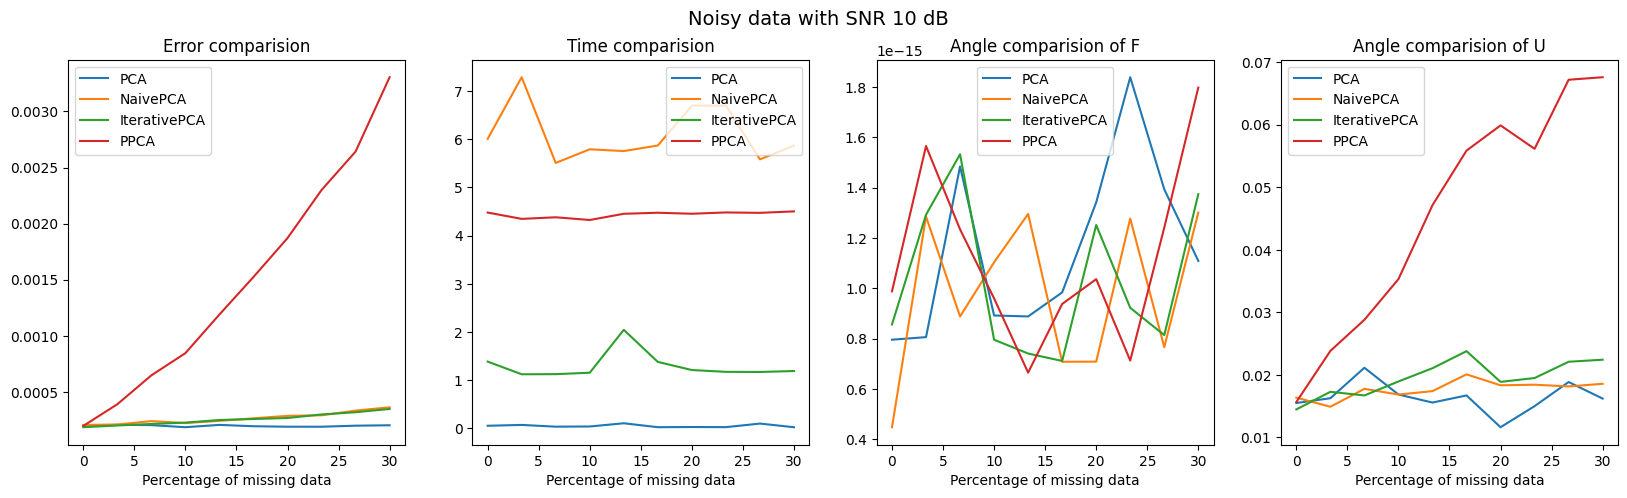

In [788]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].plot(w_values, compPCA[:, 2], label='PCA')
ax[0].plot(w_values, compNaive[:, 2], label='NaivePCA')
ax[0].plot(w_values, compIterative[:,2], label='IterativePCA')
ax[0].plot(w_values, compPPCA[:, 2], label='PPCA')
ax[0].legend()
ax[0].set_xlabel("Percentage of missing data")
ax[0].set_title("Error comparision")
ax[1].plot(w_values, compPCA[:, 3], label='PCA')
ax[1].plot(w_values, compNaive[:, 3], label='NaivePCA')
ax[1].plot(w_values, compIterative[:, 3], label='IterativePCA')
ax[1].plot(w_values, compPPCA[:, 3], label='PPCA')
ax[1].legend()
ax[1].set_xlabel("Percentage of missing data")
ax[1].set_title("Time comparision")
ax[2].plot(w_values, compPCA[:, 0], label='PCA')
ax[2].plot(w_values, compNaive[:, 0], label='NaivePCA')
ax[2].plot(w_values, compIterative[:, 0], label='IterativePCA')
ax[2].plot(w_values, compPPCA[:, 0], label='PPCA')
ax[2].set_xlabel("Percentage of missing data")
ax[2].legend()
ax[2].set_title("Angle comparision of F")
ax[3].plot(w_values, compPCA[:, 1], label='PCA')
ax[3].plot(w_values, compNaive[:, 1], label='NaivePCA')
ax[3].plot(w_values, compIterative[:, 1], label='IterativePCA')
ax[3].plot(w_values, compPPCA[:, 1], label='PPCA')
ax[3].set_xlabel("Percentage of missing data")
ax[3].legend()
ax[3].set_title("Angle comparision of U")
fig = plt.gcf()
fig.suptitle("Noisy data with SNR 10 dB", fontsize=14)
plt.savefig("pcaW1.2_10.png")

In [612]:
import scipy.io
mat = scipy.io.loadmat('/home/julia/Documents/SIGMA/Factorization/1_PCA/Programs_Students/DataDecathlon.mat')

In [753]:
X = mat['Data'].copy()
W = np.ones(X.shape)
W[np.isnan(X)] = 0
X[np.isnan(X)] = 0

In [614]:
mat_complete = scipy.io.loadmat('/home/julia/Documents/SIGMA/Factorization/DataDecathlon_Complete.mat')
name_variables = mat_complete['nameVariables'].reshape(-1)
X_complete = mat_complete['Data']

In [738]:
def comparison(X, K, method=pca_, W=None, it=1, X_complete=None):   
    if isinstance(K, int):
        mean = X.mean(0)
        X_centered = X - mean
        F, U = method(X.copy(), K, W, it)
        if X_complete is not None:
            error = norm(X_complete - np.matmul(F, U.T) + mean)**2/(M*N)
            print(error)
        else:
            error = norm(X_centered - np.matmul(F, U.T))**2/(M*N)
        return error, F, U
    else:
        _comparison, _F, _U = [], [], []
        for k in K:
            mean = X.mean(0)
            X_centered = X - mean
            F, U = method(X.copy(), k, W, it)
            if X_complete is not None:
                error = norm(X_complete - np.matmul(F, U.T) + mean)**2/(M*N)
            else:
                error = norm(X_centered - np.matmul(F, U.T))**2/(M*N)                
            _comparison += [error]
            _F += [F]
            _U += [U]
        return np.array(_comparison), _F, _U

In [764]:
remove_idx = [4, 11, 18, 24, 36, 43, 56]
new_X = np.delete(X, remove_idx, 0)
W = np.ones(new_X.shape)
W[np.isnan(new_X)] = 0
new_X[np.isnan(new_X)] = 0

In [745]:
k_values = np.arange(2, 11)

In [754]:
#compNaive = comparison(X, k_values, method=naive_pca, W=W, it=1000, X_complete=X_completeplete)
compIterative = comparison(X, k_values, method=iterative_pca, W=W, it=1000)
compPPCA = comparison(X, k_values, method=ppca, W=W, it=10000)

In [765]:
#compNaive = comparison(X, k_values, method=naive_pca, W=W, it=1000, X_complete=X_completeplete)
new_compIterative = comparison(new_X, k_values, method=iterative_pca, W=W, it=1000)
new_compPPCA = comparison(new_X, k_values, method=ppca, W=W, it=10000)

In [669]:
compIterativeC = comparison(X, k_values, method=iterative_pca, W=W, it=1000, X_complete=X_complete)
compPPCAC = comparison(X, k_values, method=ppca, W=W, it=10000, X_complete=X_complete)

77973.85297394695
77330.17842395596
75229.60186398665
77556.15339441483
75397.7437252994
74471.32483767062
73690.54321563437
72505.94632621571
71126.77594649121
63395.98203825854
63378.32700523075
63389.622474699296
63388.91728592349
63387.44056577036
63381.23431000909
63380.053037889455
63378.21367345213
63378.24156255771


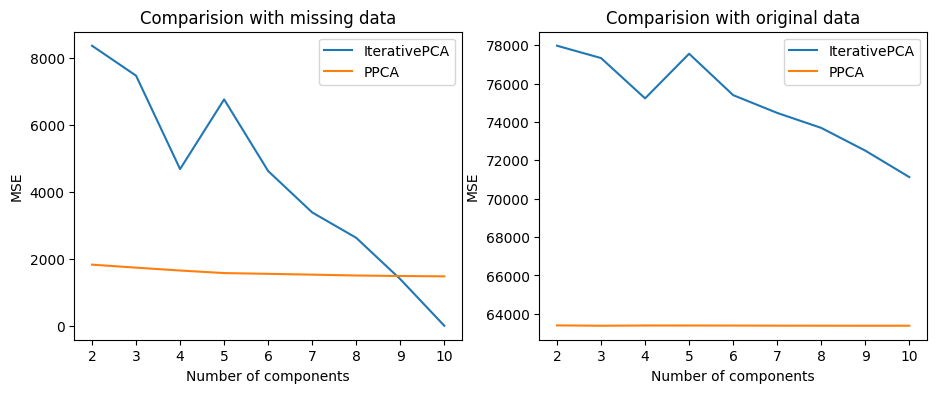

In [780]:
#plt.plot(k_values, compNaive[0], label='NaivePCA')
fig, ax = plt.subplots(1, 2, figsize=(11, 4))
ax[0].plot(k_values, compIterative[0], label='IterativePCA')
ax[0].plot(k_values, compPPCA[0], label='PPCA')
ax[1].plot(k_values, compIterativeC[0], label='IterativePCA')
ax[1].plot(k_values, compPPCAC[0], label='PPCA')
ax[0].set_xlabel("Number of components")
ax[1].set_xlabel("Number of components")
ax[0].set_ylabel("MSE")
ax[1].set_ylabel("MSE")
ax[0].set_title("Comparision with missing data")
ax[1].set_title("Comparision with original data")
ax[0].legend()
ax[1].legend()
plt.savefig("pcaDecathlon1.png")

In [749]:
from scipy.special import binom
import matplotlib.pyplot as plt
def plot_projection(C, K, selectedIndex=None):
    if selectedIndex is None:
        selectedIndex = np.arange(C.shape[0])
    ncols = np.ceil(np.sqrt(binom(K,2)) + 1).astype(int)
    nrows = np.ceil(binom(K,2)/ncols).astype(int)
    fig, ax = plt.subplots(nrows, ncols, figsize=(17, 5))
    ax_idx = 0
    axs = ax.flatten()
    for i in range(K):
        for j in range(i+1, K):
            axs[ax_idx].plot(C[:, i], C[:, j], 'o')
            [axs[ax_idx].annotate(k, (C[k, i], C[k, j])) for k in selectedIndex]
            axs[ax_idx].set_xlabel('Component ' + str(i+1))
            axs[ax_idx].set_ylabel('Component ' + str(j+1))
            ax_idx +=1
            
def plot_circles(corrcoef, features_names, K):
    ncols = np.ceil(np.sqrt(binom(K,2)) + 1).astype(int)
    nrows = np.ceil(binom(K,2)/ncols).astype(int)
    fig, ax = plt.subplots(nrows, ncols, figsize=(20, 5))
    ax_idx = 0
    axs = ax.flatten()
    for i in range(K):
        for j in range(i+1, K): 
            for k in range(len(corrcoef[:, i:j])):
                axs[ax_idx].arrow(0, 0, corrcoef[k, i], corrcoef[k, j], color = 'b', head_width=0.02, head_length=0.02)
                axs[ax_idx].text(corrcoef[k, i]* 1.10, corrcoef[k, j] * 1.10, features_names[k][0], color = 'k', ha = 'center', va = 'center', weight='bold')
            circle = plt.Circle((0, 0), 1, fill=False)
            axs[ax_idx].add_patch(circle)
            axs[ax_idx].plot([-1,1], [0,0], 'k')
            axs[ax_idx].plot([0,0], [-1,1], 'k')
            axs[ax_idx].set_xlim(-1,1)
            axs[ax_idx].set_ylim(-1,1)
            axs[ax_idx].set_xlabel("Component{}".format(i+1))
            axs[ax_idx].set_ylabel("Component{}".format(j+1))
            axs[ax_idx].grid()
            ax_idx += 1

In [766]:
corrcoef = np.empty((X.shape[1], 3))
for k in range(3):
    corrcoef[:, k] = [np.corrcoef([X[:, i], compIterative[1][3][:, k]])[0, 1] for i in range(X.shape[1])]

In [767]:
corrcoef = np.empty((new_X.shape[1], 3))
for k in range(3):
    corrcoef[:, k] = [np.corrcoef([new_X[:, i], new_compIterative[1][3][:, k]])[0, 1] for i in range(new_X.shape[1])]

In [ ]:
compIterative

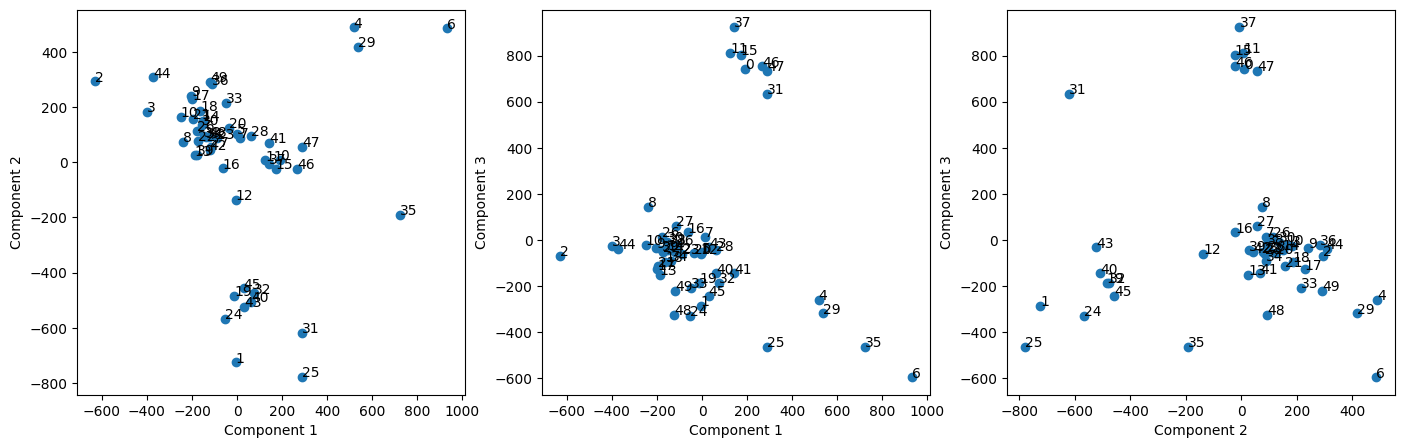

In [750]:
plot_projection(compIterative[1][1], K=3)
plt.savefig("projectionIterative_3.2.png")

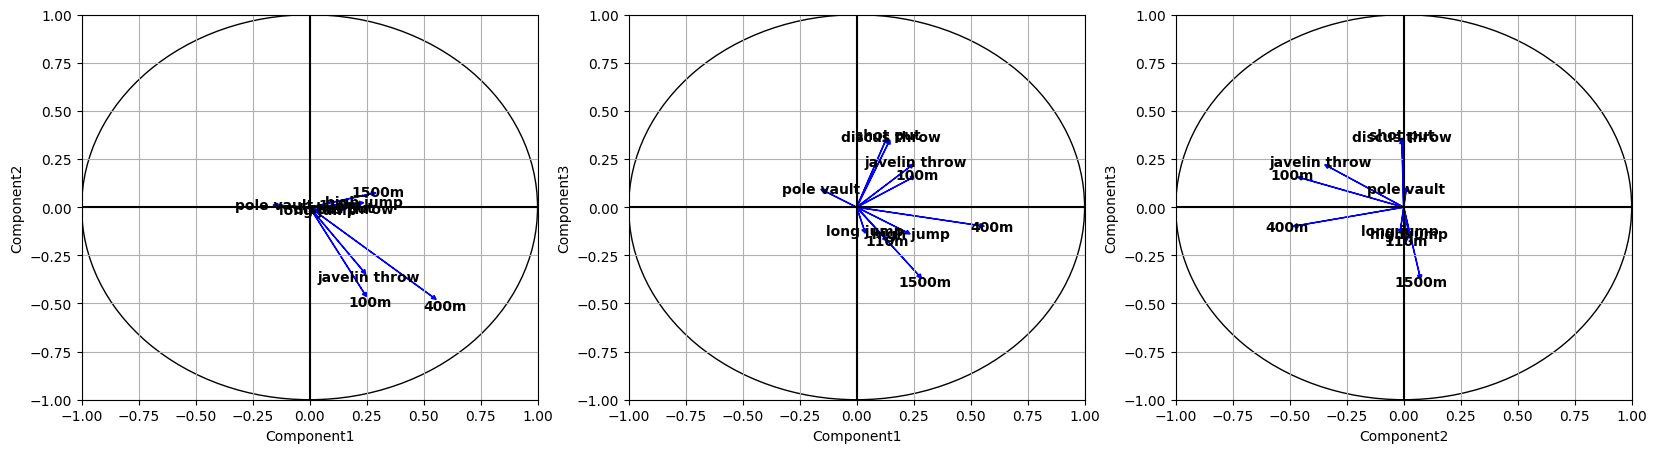

In [760]:
plot_circles(corrcoef, name_variables, K)
plt.savefig("circlesPPCA.png")

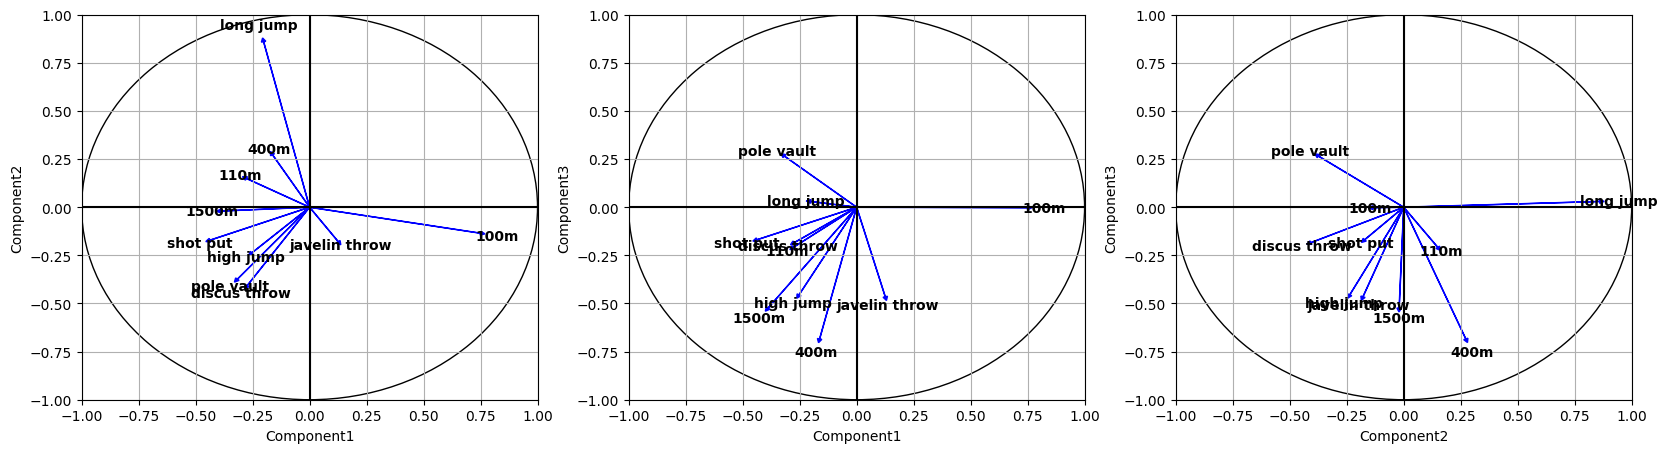

In [768]:
plot_circles(corrcoef, name_variables, K)
plt.savefig("circlesPPCA_new.png")